## Analysis of predictability

- train rnn to predict next value.
- analyse RMSE on hold out set.
- look for distrubution of RMSE on each sequence
- look for characteristics of any sequences that have lowest MSE (PCA/ICA)

In [1]:
from __future__ import division

import h5py
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM, GRU
from keras.utils import np_utils
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, mean_squared_error,mean_absolute_error,precision_score, recall_score, precision_recall_curve
np.random.seed(1234)

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
Using Theano backend.
Using gpu device 0: GeForce GTX 580 (CNMeM is disabled, cuDNN not available)


In [2]:
!ls *.h5

eurusd_2012_sequences_20.h5
eurusd_2012_sequences_60.h5
lstm_100_100_100_30x3_input_binary_classifier_20170125-222854.h5
lstm_100_100_100_30x3_input_binary_classifier_20170125-222951.h5
lstm_100_100_100_30x3_input_binary_classifier_20170125-223712.h5
lstm_100_100_100_30x3_input_binary_classifier_20170125-224632.h5
lstm_100_100_100_3input_binary_classifier_20170125-222854.h5
ohlret_sequences_30_EURUSD_2012.h5
results.h5
sequences_30_EURUSD_GBPUSD_EURGBP_2012.h5
sequences_30_EURUSD_GBPUSD_EURGBP_2013.h5
sequences_30_EURUSD_GBPUSD_EURGBP_2014.h5
xauusd_2012_sequences_20.h5
xauusd_2012_sequences_60.h5


In [36]:
fname = 'ohlret_sequences_30_EURUSD_2013.h5'

In [37]:
with h5py.File(fname, 'r') as f:
    sequences = f['sequences'][...]

In [38]:
def sgn( x): return (x>0)*1

In [39]:
sequences.shape

(340450, 30, 4)

In [40]:
train_rows = int(0.9 * sequences.shape[0])
dev_rows = int(0.1 * sequences.shape[0])

print "train rows", train_rows, "dev rows", dev_rows
train = sequences[:train_rows, :]
dev = sequences[train_rows:train_rows+dev_rows, :]
print "train shape", train.shape
print "dev shape", dev.shape

np.random.shuffle(train)
X_train = train[:, :-1,:] # tale all but last in sequence, all features
y_train = train[:,-1,0] # first column is log return. take sign of last in sequence as y.
y_train = sgn(y_train - y_train.mean()) # de-mean

X_dev = dev[:, :-1,:]
y_dev = sgn(dev[:, -1,0])

print "X_train", X_train.shape
print "X_dev", X_dev.shape

print "y_train", y_train.shape
print "y_dev", y_dev.shape

print "y_train.mean", y_train.mean()
print "y_dev.mean", y_dev.mean()

train rows 306405 dev rows 34045
train shape (306405, 30, 4)
dev shape (34045, 30, 4)
X_train (306405, 29, 4)
X_dev (34045, 29, 4)
y_train (306405,)
y_dev (34045,)
y_train.mean 0.465387314176
y_dev.mean 0.465090321633


In [41]:
# note if X contains 1 dimensional samples maybe just need 1 here, rather than X_train.shape[2]
n_features = X_train.shape[2]
#n_features =1

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], n_features))
X_dev = np.reshape(X_dev, (X_dev.shape[0], X_dev.shape[1], n_features))

print X_train.shape
print X_dev.shape

(306405, 29, 4)
(34045, 29, 4)


In [9]:
start = time.time()

model = Sequential()
model.add(LSTM(
            input_dim=n_features,
            output_dim=100,
            return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100,return_sequences=False))
#model.add(Dense(200, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(output_dim=1, activation="sigmoid"))

model.compile(loss='binary_crossentropy', optimizer='adam')
#model.compile(loss="mse", optimizer="adam")
print "model construct and compile time : ", time.time() - start

model construct and compile time :  0.502748966217


In [42]:
%%time 
epochs=10
batch_size=4000
hist=model.fit(
    X_train, y_train,
    batch_size=batch_size, nb_epoch=epochs, validation_split=0.05)
hist.history

Train on 291084 samples, validate on 15321 samples
Epoch 1/10
291084/291084 [==============================] - 97s - loss: 0.6891 - val_loss: 0.6877

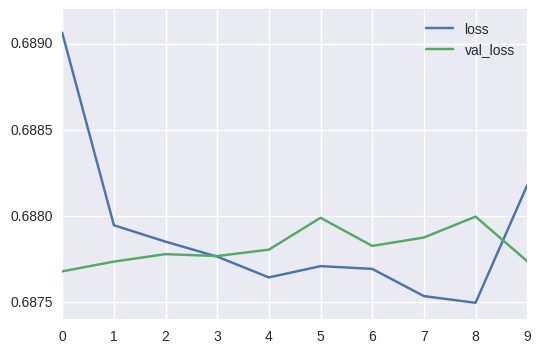

In [43]:
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend()

In [44]:
import datetime as dt
ts = dt.datetime.now().strftime("%Y%m%d-%H%M%S")

model.save("lstm_100_100_100_30x4_input_binary_classifier_{ts}.h5".format(ts=ts))

In [45]:
train_prediction = model.predict(X_train, batch_size=1024, verbose=True)
dev_prediction = model.predict(X_dev, batch_size=1024, verbose=True)

34045/34045 [==============================] - 2s     

In [46]:
print  train_prediction.mean(), y_train.mean()
print  dev_prediction.mean(), y_dev.mean()

0.465992 0.465387314176
0.462998 0.465090321633


In [47]:
print "train set rmse rel std.", np.sqrt(mean_squared_error(y_train, train_prediction))/y_train.std()
print "train set mae rel std.", mean_absolute_error(y_train, train_prediction)/y_train.std()

print "dev set rmse rel std.", np.sqrt(mean_squared_error(y_dev, dev_prediction))/y_dev.std()
print "dev set mae rel std.", mean_absolute_error(y_dev, dev_prediction)/y_dev.std()

train set rmse rel std. 0.996693319716
train set mae rel std. 0.99178866375
dev set rmse rel std. 0.996869383769
dev set mae rel std. 0.991683132194


In [48]:
print train_prediction.ravel().shape
print  y_train.shape
print dev_prediction.ravel().shape
print y_dev.shape
y_dev

(306405,)
(306405,)
(34045,)
(34045,)


array([0, 1, 1, ..., 0, 0, 1])

In [49]:
thresh = 0.50
print "confusion matrix\n", confusion_matrix(y_train, train_prediction > thresh)
print "accuracy", accuracy_score(y_train, train_prediction > thresh)
print "precision", precision_score(y_train, train_prediction > thresh)
print "recall", recall_score(y_train, train_prediction> thresh)
print "f1 score", f1_score(y_train, train_prediction> thresh)

confusion matrix
[[138978  24830]
 [114508  28089]]
accuracy 0.545248935233
precision 0.530792343015
recall 0.196981703682
f1 score 0.28733198306


In [50]:
thresh = 0.50
print "confusion matrix\n", confusion_matrix(y_dev, dev_prediction > thresh)
print "accuracy", accuracy_score(y_dev, dev_prediction > thresh)
print "precision", precision_score(y_dev, dev_prediction > thresh)
print "recall", recall_score(y_dev, dev_prediction> thresh)
print "f1 score", f1_score(y_dev, dev_prediction> thresh)

confusion matrix
[[15788  2423]
 [13129  2705]]
accuracy 0.543192833015
precision 0.527496099844
recall 0.170834912214
f1 score 0.25808606049


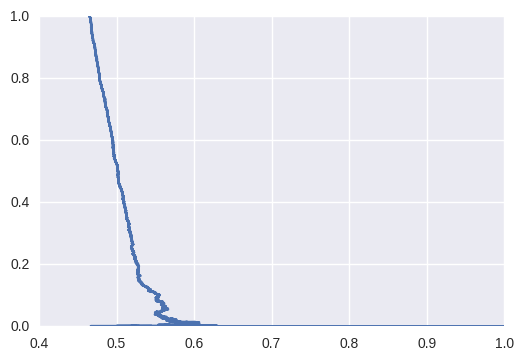

In [51]:
curve = precision_recall_curve(y_dev, dev_prediction )
plt.plot(curve[0], curve[1])

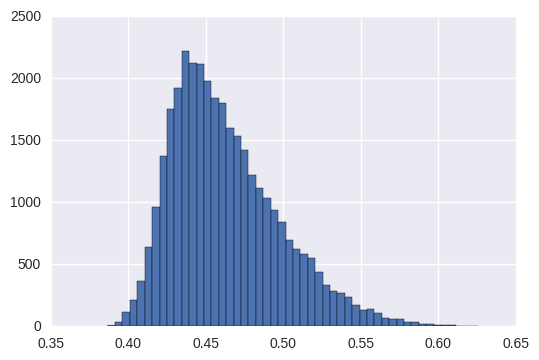

In [52]:
plt.hist(dev_prediction, bins=50);

In [64]:
from keras.utils.visualize_util import plot
plot(model, to_file='model.png')